In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from preprocessing import load_diabetes_prepr

from sklearn.inspection import PartialDependenceDisplay

In [2]:
def fit_and_error(X, y, seed, model, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

In [3]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('neg_root_mean_squared_error'), cv=KFold())
    clf.fit(X_train, y_train)

    return clf

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

In [4]:
X, y, feature_names = load_diabetes_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Decision tree regressor

In [5]:
model_name = "decision tree regressor"
parameters = {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), 'splitter': ('best', 'random') , 'min_samples_split': np.arange(2, 301)}
tr = tree.DecisionTreeRegressor(random_state=seed)

clf = find_best_model(tr, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

RMSE (decision tree regressor): 66.50845607349149
R-squared score (decision tree regressor) : 0.4192673441013629


DecisionTreeRegressor(min_samples_split=71, random_state=3012)

<AxesSubplot:>

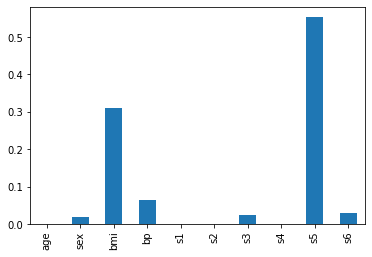

In [6]:
model = clf.best_estimator_
df = pd.Series(data=model.feature_importances_, index=feature_names)
df.plot.bar()

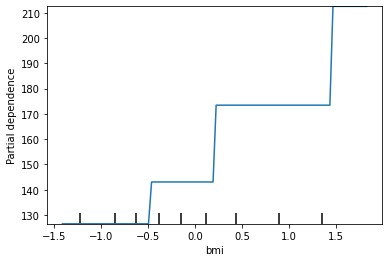

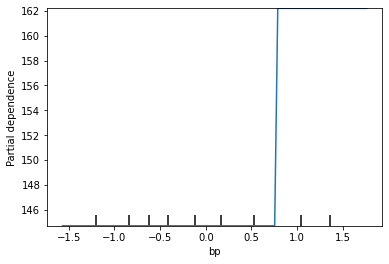

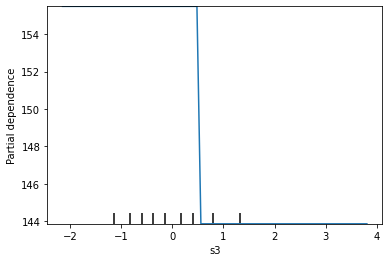

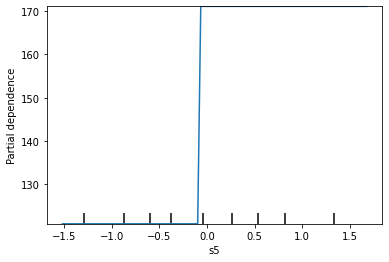

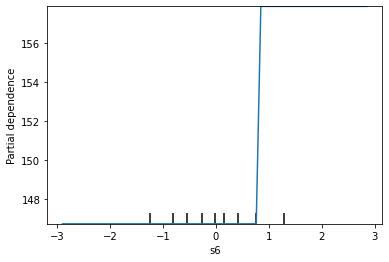

In [7]:
for i in range(len(feature_names)):
    if i not in [0, 1, 4, 5, 7]:
        PartialDependenceDisplay.from_estimator(model, X, [i], feature_names=feature_names, method="brute")

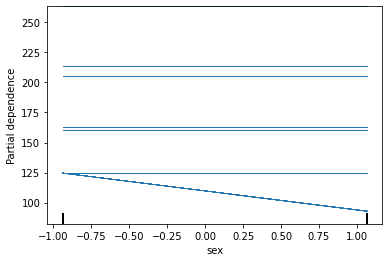

In [8]:
PartialDependenceDisplay.from_estimator(model, X, [1], feature_names=feature_names, percentiles=(0.0, 1.0), kind="individual")

In [9]:
unique = np.unique(X[:,1])
PDP = list()
for value in unique:
    X_copy = np.copy(X)
    X_copy[:,1] = value
    predictions = model.predict(X_copy)
    PDP.append(np.mean(predictions))

print(unique)
print(PDP)

[-0.93853666  1.06548848]
[152.73202236109816, 146.063763383657]


In [10]:
from sklearn.inspection import partial_dependence
pdp, axes = partial_dependence(model, X, [2], method="brute", percentiles=(0.0, 1.0))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/inspection/_partial_dependence.py:523: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,


# Linear regression models

In [11]:
model_name = "linear regression"
parameters = {}
linreg = LinearRegression()

clf = find_best_model(linreg, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

RMSE (linear regression): 58.94293390689424
R-squared score (linear regression) : 0.543872754881746


LinearRegression()

<AxesSubplot:>

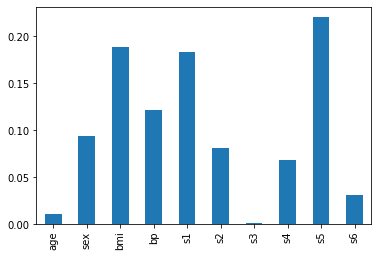

In [12]:
model = clf.best_estimator_
df = pd.Series(data=np.abs(model.coef_)/np.sum(np.abs(model.coef_)), index=feature_names)
df.plot.bar()

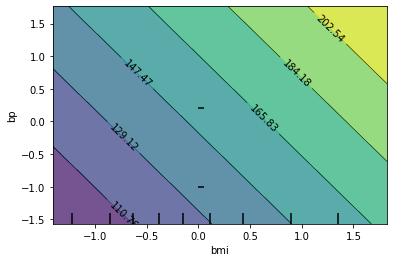

In [13]:
PartialDependenceDisplay.from_estimator(model, X, [(2, 3)], feature_names=feature_names)

In [14]:
model_name = "Ridge linear regression"
parameters = {'alpha': np.geomspace(1e-7, 100, 10)}
ridge = Ridge()

clf = find_best_model(ridge, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

RMSE (Ridge linear regression): 59.484735074656925
R-squared score (Ridge linear regression) : 0.5354488077330009


Ridge(alpha=10.0)

<AxesSubplot:>

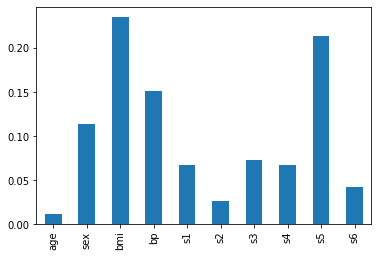

In [15]:
model = clf.best_estimator_
df = pd.Series(data=np.abs(model.coef_)/np.sum(np.abs(model.coef_)), index=feature_names)
df.plot.bar()

In [16]:
model_name = "Lasso linear regression"
parameters = {'alpha': np.geomspace(1e-5, 100, 80)}
lasso = Lasso()

clf = find_best_model(lasso, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

RMSE (Lasso linear regression): 59.370755666566
R-squared score (Lasso linear regression) : 0.5372273662654825


Lasso(alpha=0.6092704661368674)

<AxesSubplot:>

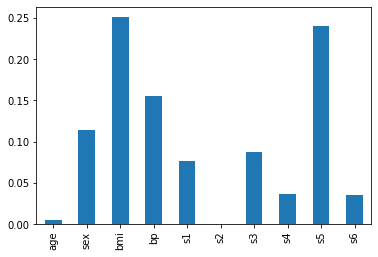

In [17]:
model = clf.best_estimator_
df = pd.Series(data=np.abs(model.coef_)/np.sum(np.abs(model.coef_)), index=feature_names)
df.plot.bar()

In [18]:
seed = 3012

fit_and_error(X, y, seed, LinearRegression(), "linear regression")
fit_and_error(X, y, seed, Ridge(alpha = 0.01), "small Ridge")
fit_and_error(X, y, seed, Ridge(alpha = 100), "big Ridge")
fit_and_error(X, y, seed, Lasso(alpha = 0.01), "small Lasso")
fit_and_error(X, y, seed, Lasso(alpha = 10), "big Lasso")

RMSE (linear regression): 58.94293390689424
R-squared score (linear regression) : 0.543872754881746
RMSE (small Ridge): 58.94456991506052
R-squared score (small Ridge) : 0.5438474341790089
RMSE (big Ridge): 61.37606517591994
R-squared score (big Ridge) : 0.505438163692325
RMSE (small Lasso): 58.96732322607737
R-squared score (small Lasso) : 0.5434952054861255
RMSE (big Lasso): 65.01447173000717
R-squared score (big Lasso) : 0.4450643931762759


# KNN regressor

In [19]:
model_name = "k-nearest neighbors"
parameters = {'n_neighbors': np.arange(1, 280), 'weights': ('uniform', 'distance')}
kNN = KNeighborsRegressor()

clf = find_best_model(kNN, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

RMSE (k-nearest neighbors): 64.45688846172169
R-squared score (k-nearest neighbors) : 0.4545421586812478


KNeighborsRegressor(n_neighbors=18, weights='distance')

In [20]:
model_name = "decision tree"

parameters = {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), 'splitter': ('best', 'random') , 'min_samples_split': np.arange(2, 301)}
tr = tree.DecisionTreeRegressor(random_state=seed)
clf = GridSearchCV(tr, parameters, scoring=('neg_mean_squared_error', 'r2'), cv=KFold())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE ({}): {}".format(model_name, rmse))

clf.best_estimator_

ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.

In [ ]:
seed = 3012
fit_and_error(X, y, seed, KNeighborsRegressor(n_neighbors=19), "KNN regressor")

kf = KFold()

kNN = KNeighborsRegressor()
i = 1

for train_ind, test_ind in kf.split(X, y):
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    kNN.fit(X_train, y_train)
    y_pred = kNN.predict(X_test)

    model_name = "Fold " + str(i)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

    i += 1

RMSE (KNN regressor): 64.94701451098622
R-squared score (KNN regressor) : 0.44621536745386015
RMSE (Fold 1): 56.27781010409307
R-squared score (Fold 1) : 0.3500881704895432
RMSE (Fold 2): 63.42066440961733
R-squared score (Fold 2) : 0.36602995137367067
RMSE (Fold 3): 59.63695849204433
R-squared score (Fold 3) : 0.43172984693193817
RMSE (Fold 4): 59.59086644475279
R-squared score (Fold 4) : 0.32312430274373505
RMSE (Fold 5): 61.70551028879026
R-squared score (Fold 5) : 0.41156845751616766


# Random forest regressor

In [ ]:
seed = 3012
fit_and_error(X, y, seed, RandomForestRegressor(random_state=seed), "Random forest regressor")

RMSE (Random forest regressor): 62.51999926315714
R-squared score (Random forest regressor) : 0.4868309635840259


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5161fece-8ef6-4825-9ea6-16ebba884483' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>